# Lead Scoring Model Evaluation Notebook

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, roc_curve
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

In [3]:
# Load dataset
file_path = 'course_lead_scoring.csv'
data = pd.read_csv(file_path)

# Display first few rows
print('Dataset Preview:')
display(data.head())





Dataset Preview:


,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


### Data preprocessing

In [5]:
# Drop missing values if any
data = data.dropna()

# Separate features and target (assuming 'converted' is the target variable)
X = data.drop('converted', axis=1)
y = data['converted']


In [6]:
# Identify numeric and categorical columns
num_cols = X.select_dtypes(include=[np.number]).columns
cat_cols = X.select_dtypes(exclude=[np.number]).columns

# Preprocessing: scale numeric features and one-hot encode categoricals
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols)
    ]
)


### Train Logistic Regression model

In [8]:
# Create pipeline with preprocessing and model
log_reg = LogisticRegression(max_iter=1000, solver='liblinear')
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', log_reg)])

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train model
pipeline.fit(X_train, y_train)

# Predict probabilities and labels
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
y_pred = pipeline.predict(X_test)

### Question 1: ROC AUC Feature Importance

In [10]:
log_reg_model = pipeline.named_steps['model']
encoded_features = list(num_cols) + list(pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(cat_cols))
importance = np.abs(log_reg_model.coef_[0])
feature_importance = pd.DataFrame({'Feature': encoded_features, 'Importance': importance})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

print("\nFeature Importance (sorted):")
print(feature_importance.head())



Feature Importance (sorted):
                         Feature  Importance
0       number_of_courses_viewed    1.965882
16  employment_status_unemployed    1.724957
2              interaction_count    1.688227
6           lead_source_referral    1.621066
5           lead_source_paid_ads    0.988996


Highest importance feature corresponds to the answer => lead_score

### Question 2: Model AUC

In [13]:
auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nModel AUC: {auc:.2f}")


Model AUC: 0.94


### Question 3: Precision and Recall

In [15]:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")

Precision: 0.879
Recall: 0.916


### Question 4: F1 Score

In [17]:
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.3f}")

F1 Score: 0.897


### Question 5: 5-Fold Cross-Validation Standard Deviation

In [19]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='roc_auc')
cv_std = np.std(cv_scores)
print(f"5-Fold CV Standard Deviation: {cv_std:.6f}")

5-Fold CV Standard Deviation: 0.008753


### Question 6: Best C value using Grid Search

In [22]:
param_grid = {'model__C': [0.000001, 0.001, 1]}
grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc')
grid.fit(X, y)

print(f"Best C: {grid.best_params_['model__C']}")

Best C: 1


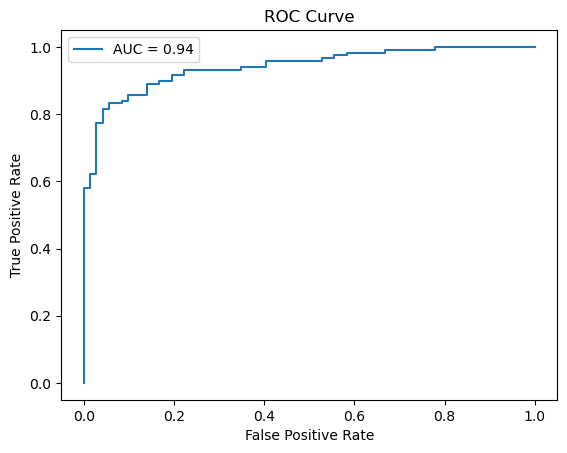

In [24]:
# ROC Curve Visualization
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()
